# Final Assignment for Coursera Specialization: IBM Data Science Professional Certificate

## 

Installing and importing all required libraries. This may take some time. 
Libraries:

1. numpy - improved numerical representations
1. pandas - data frames
1. time - (here) used to allow pausing code execution, which helps to avoid request denials due to high traffic web requests
1. re - regular expression; contains useful methods for datatype STR
1. itertools - simplifying loops
1. urllib - handles HTML requests
1. requests - handles JSON requests
1. bs4 - scrapes STR data of various forms, including HTML source code
1. geopy - gets coordinates for locations
1. matplotlib - plotting routines
1. folium - improved map plots
1. wordcloud - creates word clouds
1. sklearn - machine learning methods, here: KMeans

In [119]:
# install software libraries
# install Geopy
# !conda install -c conda-forge geopy --yes 
# install wordcloud
# !conda install -c conda-forge wordcloud==1.4.1 --yes
# install Folium
# !conda install -c conda-forge folium=0.5.0 --yes

In [155]:
# import python libraries
import numpy as np
import pandas as pd
import time
import re
import itertools
from urllib import request
import requests # library to handle requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude valuesimport matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium # map rendering library
from wordcloud import WordCloud, STOPWORDS
from sklearn.cluster import KMeans

%matplotlib inline

In [3]:
# The code was removed by Watson Studio for sharing.

In [4]:
US_Cities_list_wiki="https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population"
CA_Cities_list_wiki="https://en.wikipedia.org/wiki/List_of_the_100_largest_municipalities_in_Canada_by_population"

US_Cities_soup=BeautifulSoup(request.urlopen(US_Cities_list_wiki), 'html.parser')
CA_Cities_soup=BeautifulSoup(request.urlopen(CA_Cities_list_wiki), 'html.parser')

print('The title tag of the imported US City list HTML is:\n\n' + US_Cities_soup.title.prettify() + '\n')
print('The title tag of the imported Canada City list HTML is:\n\n' + CA_Cities_soup.title.prettify() + '\n')

The title tag of the imported US City list HTML is:

<title>
 List of United States cities by population - Wikipedia
</title>


The title tag of the imported Canada City list HTML is:

<title>
 List of the 100 largest municipalities in Canada by population - Wikipedia
</title>




Creating tables from html strings and cleaning tables:

In [5]:
# US Cities:
list_USC = pd.read_html(str(US_Cities_soup.find('table',{'class':"wikitable sortable"})))
df_USC   = pd.DataFrame(list_USC[0])
print("US Cities over 100k inhabitants:")
print(df_USC.head())
# Canadian Cities:
list_CAC = pd.read_html(str(CA_Cities_soup.find('table',{'class':"wikitable sortable"})))
df_CAC   = pd.DataFrame(list_CAC[0])
print("\nCanadian Cities over 100k inhabitants:")
print(df_CAC.head())
# Cleaning tables to include only city name and population (sort value), only include cities with more than 100000 registered inhabitants. 
df_USC=df_USC[['City','State[c]','2019estimate']]
df_USC.rename(columns={'State[c]':'Province/State','2019estimate':'Population'},inplace=True)
df_CAC=df_CAC[df_CAC['Population(2016)']>100000]
df_CAC=df_CAC[['Municipality','Province','Population(2016)']]
df_CAC.rename(columns={'Municipality':'City','Province':'Province/State','Population(2016)':'Population'},inplace=True)
# Some city names need cleaning from footnote markers in source.
df_USC['City'] = [re.sub("\[\w+\]","",city) for city in list(df_USC['City'])]
df_USC['Province/State'] = [re.sub("\[\w+\]","",state) for state in list(df_USC['Province/State'])]
df_CAC['City'] = [re.sub("\[\w+\]","",city) for city in list(df_CAC['City'])]
df_CAC['Province/State'] = [re.sub("\[\w+\]","",state) for state in list(df_CAC['Province/State'])]
# Combining US and Canadian cities in one dataframe
df_cities=pd.concat([df_USC,df_CAC]).sort_values('Population',ascending=False).reset_index(drop=True)
print("\nTail(20) of dataframe of all Cities:")
df_cities.tail(20)

US Cities over 100k inhabitants:
   2019rank         City    State[c]  2019estimate  2010Census   Change  \
0         1  New York[d]    New York       8336817     8175133   +1.98%   
1         2  Los Angeles  California       3979576     3792621   +4.93%   
2         3      Chicago    Illinois       2693976     2695598   −0.06%   
3         4   Houston[3]       Texas       2320268     2100263  +10.48%   
4         5      Phoenix     Arizona       1680992     1445632  +16.28%   

  2016 land area 2016 land area.1 2016 population density  \
0    301.5 sq mi        780.9 km2            28,317/sq mi   
1    468.7 sq mi      1,213.9 km2             8,484/sq mi   
2    227.3 sq mi        588.7 km2            11,900/sq mi   
3    637.5 sq mi      1,651.1 km2             3,613/sq mi   
4    517.6 sq mi      1,340.6 km2             3,120/sq mi   

  2016 population density.1                                         Location  
0                10,933/km2    40°39′49″N 73°56′19″W﻿ / ﻿40.6635°N 73.

,City,Province/State,Population
351,Las Cruces,New Mexico,103432
352,Chico,California,103301
353,El Cajon,California,102708
354,Burbank,California,102511
355,Delta,British Columbia,102238
356,South Bend,Indiana,102026
357,Renton,Washington,101751
358,Chatham-Kent,Ontario,101647
359,Vista,California,101638
360,Davenport,Iowa,101590


Let's get all coordinates for the cities. Here we request the location data from Geopy and add it to the dataframe. Note, that it appears that calls to Geopy are limited in number during a specific time, therefore we may need to iterate several times through the Geopy call as there can be denied requests.


In [9]:
cities_file="cities.pkl"
try:
    df_cities = pd.read_pickle(cities_file)
except:
    # initialise the new columns
    if 'Latitude' not in df_cities.columns:
        df_cities['Latitude']=np.nan
    if 'Longitude' not in df_cities.columns:
        df_cities['Longitude']=np.nan
    # initialise geopy parameter
    geolocator = Nominatim(user_agent="geo_explorer")
    # repeat until the last city has coordinates
    while np.isnan(df_cities.loc[df_cities.index[-1],'Latitude']):
        # iterate through all cities starting from the first
        for city,reg in zip(list(df_cities['City']),list(df_cities['Province/State'])):
            try:
                if np.isnan(df_cities[(df_cities['City']==city)&(df_cities['Province/State']==reg)]['Latitude'].values):
                    # if the city does not yet have coordinates, request them from Geopy for city + province/state
                    location = geolocator.geocode(city+", "+reg)
                    latitude = location.latitude
                    longitude = location.longitude
                    df_cities.loc[(df_cities['City']==city)&(df_cities['Province/State']==reg),'Latitude']=latitude
                    df_cities.loc[(df_cities['City']==city)&(df_cities['Province/State']==reg),'Longitude']=longitude
                    print(location)
            except:
                # sometimes geopy denies the request (perhaps due to many requests in a given, short time). 
                # Should that be the case, we wait a moment before trying again.
                print("Request denied! Let's try again after one second.")
                time.sleep(1)
                break
    df_cities.reset_index(inplace=True)
    df_cities.to_pickle(cities_file)
df_cities.tail()

,index,City,Province/State,Population,Latitude,Longitude
366,366,Vacaville,California,100670,38.356577,-121.987744
367,367,Clinton,Michigan,100471,42.943524,-84.612534
368,368,Bend,Oregon,100421,44.058173,-121.315310
369,369,Red Deer,Alberta,100418,52.269838,-113.818359
370,370,Woodbridge,New Jersey,100145,40.554180,-74.286001


Now that we have location data we can search the Foursquare data base for all restaurants that are in these cities at around 5km of the city center. We limit the results to 1000 per city.

In [13]:
# function that returns nearby restaurants for 5000m around the center of a city
def getNearbyRestaurants(idxs, names, regs, latitudes, longitudes, radius=5000, LIMIT=100):
    
    restaurants_list=[]
    for idx, name, reg, lat, lng in zip(idxs, names, regs, latitudes, longitudes):
        print(name + ", " + reg)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            'Lunch',
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except:
            results=[]
        
        # return only relevant information for each nearby venue
        restaurants_list.append([(
            idx,
            name, 
            reg,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_restaurants = pd.DataFrame([item for restaurant_list in restaurants_list for item in restaurant_list])
    try:
        nearby_restaurants.columns = ['index', 
                  'City',
                  'Province/State',
                  'City Latitude', 
                  'City Longitude', 
                  'Restaurant', 
                  'Restaurant Latitude', 
                  'Restaurant Longitude', 
                  'Restaurant Category']
    except:
        pass
    
    return(nearby_restaurants)

In [15]:
restaurants_file="restaurants.pkl"
try:
    df_restaurants = pd.read_pickle(restaurants_file)
except:
    df_restaurants = getNearbyRestaurants(
                                    idxs=df_cities['index'],
                                    names=df_cities['City'],
                                    regs=df_cities['Province/State'],
                                    latitudes=df_cities['Latitude'],
                                    longitudes=df_cities['Longitude']
                                  )
    df_restaurants.to_pickle(restaurants_file)
    
df_restaurants.tail(20)

New York, New York
Los Angeles, California
Toronto, Ontario
Chicago, Illinois
Houston, Texas
Montreal, Quebec
Phoenix, Arizona
Philadelphia, Pennsylvania
San Antonio, Texas
San Diego, California
Dallas, Texas
Calgary, Alberta
San Jose, California
Austin, Texas
Ottawa, Ontario
Edmonton, Alberta
Jacksonville, Florida
Fort Worth, Texas
Columbus, Ohio
Charlotte, North Carolina
San Francisco, California
Indianapolis, Indiana
Seattle, Washington
Denver, Colorado
Mississauga, Ontario
Washington, District of Columbia
Winnipeg, Manitoba
Boston, Massachusetts
El Paso, Texas
Nashville, Tennessee
Detroit, Michigan
Oklahoma City, Oklahoma
Portland, Oregon
Las Vegas, Nevada
Memphis, Tennessee
Vancouver, British Columbia
Louisville, Kentucky
Brampton, Ontario
Baltimore, Maryland
Milwaukee, Wisconsin
Albuquerque, New Mexico
Tucson, Arizona
Hamilton, Ontario
Quebec City, Quebec
Fresno, California
Mesa, Arizona
Surrey, British Columbia
Sacramento, California
Atlanta, Georgia
Kansas City, Missouri
Colora

,index,City,Province/State,City Latitude,City Longitude,Restaurant,Restaurant Latitude,Restaurant Longitude,Restaurant Category
32443,370,Woodbridge,New Jersey,40.55418,-74.286001,Philly Pretzel Factory,40.533934,-74.334284,Restaurant
32444,370,Woodbridge,New Jersey,40.55418,-74.286001,MIRCHI SOUTH INDIAN HOMESTYLE,40.572420,-74.339937,Indian Restaurant
32445,370,Woodbridge,New Jersey,40.55418,-74.286001,Garibaldi Mexican Restaurant,40.510457,-74.275454,Mexican Restaurant
32446,370,Woodbridge,New Jersey,40.55418,-74.286001,Mithaas,40.571129,-74.339450,Indian Restaurant
32447,370,Woodbridge,New Jersey,40.55418,-74.286001,White Castle,40.546761,-74.328751,Fast Food Restaurant
32448,370,Woodbridge,New Jersey,40.55418,-74.286001,El Tex Mex Burrito & Cafe,40.527937,-74.312611,Mexican Restaurant
32449,370,Woodbridge,New Jersey,40.55418,-74.286001,Shalimar Kandahar Afghani & Turkish Restaurant,40.573831,-74.325912,Afghan Restaurant
32450,370,Woodbridge,New Jersey,40.55418,-74.286001,Sigiri,40.557238,-74.343664,Sri Lankan Restaurant
32451,370,Woodbridge,New Jersey,40.55418,-74.286001,Singa's Famous Pizza,40.571092,-74.339387,Pizza Place
32452,370,Woodbridge,New Jersey,40.55418,-74.286001,Panera Bread,40.548218,-74.335426,Bakery


In [148]:
Cuisines={'Italian','Mexican','Japanese','Chinese','Thai','Asian','Vietnamese','Indian',#'New American','American',
          'Modern European','Mediterranean','Greek','French','Middle Eastern','Latin American','Korean','Spanish','Caribbean','Cuban',
          'German','Peruvian','Brazilian','Israeli','African','Hawaiian','South American','Portuguese','Argentinian','South East Asian',
          'Filipino','Eastern European','Turkish','Mongolian','Afghan','East European','Scandinavian','Pakistani','Taiwanese','Australian'}
patterns=re.compile(r'( Restaurant)|( Place)') 
df_restaurants_sub=df_restaurants[['index','Restaurant Category']].loc[[patterns.search(rest) is not None for rest in df_restaurants['Restaurant Category']]]
df_restaurants_sub['Restaurant Category']=[rest[0:(patterns.search(rest).span()[0])] for rest in df_restaurants_sub['Restaurant Category']]
df_restaurants_sub.reset_index(inplace=True,drop=True)
#df_restaurants_sub['Restaurant Category'].value_counts()
replace_dict={'Pizza':'Italian','Indian Chinese':'Indian','Japanese Curry':'Japanese','Paella':'Spanish','Empanada':'Argentinian',
              'North Indian':'Indian','Udon':'Japanese','Cajun / Creole':'Japanese','Burrito':'Mexican','Tibetan':'Indian',
              'Venezuelan':'Latin American','Jewish':'Israeli','Ramen':'Japanese','Taco':'Mexican','Sushi':'Japanese','Bavarian':'German',
              'Persian':'Middle Eastern','Tex-Mex':'Mexican','Himalayan':'Indian','Tapas':'Spanish','Caucasian':'East European',
              'Polish':'East European','Romanian':'East European','Russian':'East European','Hong Kong':'Chinese','Falafel':'Israeli',
              'Hungarian':'East European','South Indian':'Indian','Shanghai':'Chinese','Cantonese':'Chinese','Iraqi':'Middle Eastern',
              'Arepa':'Argentinian','Moroccan':'African','Chaat':'Indian','Soba':'Japanese','Indonesian':'South East Asian',
              'Satay':'South East Asian','Shabu-Shabu':'Japanese','Donburi':'Japanese','Hunan':'Chinese','Salvadoran':'Caribbean',
              'Hotpot':'Chinese','Burmese':'South East Asian','Sri Lankan':'South East Asian','Doner':'Turkish','Kebab':'Turkish',
              'Dim Sum':'Chinese','Malay':'South East Asian','Szechuan':'Chinese','Belgian':'Modern European','English':'Modern European',
              'Fondue':'Modern European','Lebanese':'African','Ethiopian':'African','Colombian':'South American',
              'Cambodian':'South East Asian','Poke':'Hawaiian'}
replace_pattern = re.compile(r'\b(' + '|'.join(replace_dict.keys()) + r')\b')
df_restaurants_sub['Restaurant Category'] = [replace_pattern.sub(lambda x: replace_dict[x.group()], string) for string in df_restaurants_sub['Restaurant Category']]
df_restaurants_sub['Restaurant Category'].value_counts()
df_restaurants_sub['Restaurant Category'] = df_restaurants_sub['Restaurant Category'].loc[[cuisine in Cuisines for cuisine in list(df_restaurants_sub['Restaurant Category'])]]
df_restaurants_sub.dropna(axis=0,inplace=True)
df_restaurants_sub.rename(columns={'Restaurant Category':'Cuisine'},inplace=True)
df_restaurants_sub.reset_index(inplace=True,drop=True)
df_restaurants_sub['Cuisine'].value_counts()


Italian             3828
Mexican             3344
Japanese            1481
Chinese             1019
Thai                 617
Asian                541
Vietnamese           489
Indian               368
Mediterranean        333
Greek                242
French               211
Middle Eastern       205
Latin American       177
Korean               165
Spanish              118
Caribbean            114
Cuban                 83
Hawaiian              78
German                67
Peruvian              65
Israeli               58
Brazilian             58
African               52
South American        43
Portuguese            41
Argentinian           39
Modern European       35
South East Asian      28
Filipino              27
Eastern European      26
Turkish               20
Mongolian             16
Afghan                13
East European         10
Scandinavian          10
Pakistani              9
Taiwanese              8
Australian             4
Name: Cuisine, dtype: int64

In [197]:
def return_str(df,cluster_idx=0):
    if 'Cluster Labels' in df.columns:
        temp=df.drop(columns=['City'])
        temp=temp.loc[temp['Cluster Labels'] == cluster_idx, temp.columns[[1] + list(range(5, temp.shape[1]))]].values.tolist()
        temp=list(itertools.chain(*temp))
    else:
        temp=list(df['Cuisine'])
    
    temp=" ".join(temp)
    return(temp)
df_restaurants_sub.shape

(14042, 2)

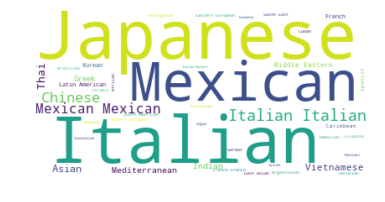

In [198]:

restaurant_cloud = WordCloud(
    background_color='white',
    max_words=20000,
    stopwords=STOPWORDS
)

# generate string of all cuisines from dataframe
restaurant_str=return_str(df_restaurants_sub)
# generate the word cloud
restaurant_cloud.generate(restaurant_str)

# display the word cloud
plt.imshow(restaurant_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()



In [152]:
# one hot encoding
restaurants_onehot = pd.get_dummies(df_restaurants_sub[['Cuisine']], prefix="", prefix_sep="")
restaurants_onehot['index'] = df_restaurants_sub['index']
restaurants_grouped = restaurants_onehot.groupby('index').mean().reset_index()
restaurants_grouped.tail()

,index,Afghan,African,Argentinian,Asian,Australian,Brazilian,Caribbean,Chinese,Cuban,...,Peruvian,Portuguese,Scandinavian,South American,South East Asian,Spanish,Taiwanese,Thai,Turkish,Vietnamese
343,365,0.000000,0.0,0.0,0.026316,0.0,0.0,0.000000,0.052632,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.026316
344,366,0.000000,0.0,0.0,0.066667,0.0,0.0,0.000000,0.111111,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.066667,0.000000,0.044444
345,368,0.000000,0.0,0.0,0.046512,0.0,0.0,0.000000,0.046512,0.0,...,0.046512,0.0,0.0,0.0,0.000000,0.023256,0.0,0.069767,0.000000,0.069767
346,369,0.000000,0.0,0.0,0.086957,0.0,0.0,0.000000,0.130435,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.086957,0.000000,0.086957
347,370,0.017544,0.0,0.0,0.035088,0.0,0.0,0.035088,0.087719,0.0,...,0.017544,0.0,0.0,0.0,0.017544,0.035088,0.0,0.000000,0.017544,0.000000


In [158]:
def return_most_common(row, num_top):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top]

num_top = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['index']
for ind in np.arange(num_top):
    try:
        columns.append('{}{} Most Common Cuisine'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Cuisine'.format(ind+1))

# create a new dataframe
restaurants_sorted = pd.DataFrame(columns=columns)
restaurants_sorted['index'] = restaurants_grouped['index']

for ind in np.arange(restaurants_grouped.shape[0]):
    restaurants_sorted.iloc[ind, 1:] = return_most_common(restaurants_grouped.iloc[ind, :], num_top)

restaurants_sorted.head()

,index,1st Most Common Cuisine,2nd Most Common Cuisine,3rd Most Common Cuisine,4th Most Common Cuisine,5th Most Common Cuisine,6th Most Common Cuisine,7th Most Common Cuisine,8th Most Common Cuisine,9th Most Common Cuisine,10th Most Common Cuisine
0,0,Italian,Israeli,French,Mexican,African,Caribbean,Chinese,Indian,Japanese,Mediterranean
1,1,Japanese,Mexican,Italian,Chinese,French,Asian,Mediterranean,Brazilian,Filipino,German
2,2,Italian,Japanese,Mexican,French,Thai,Hawaiian,Middle Eastern,Chinese,Indian,Turkish
3,3,Italian,Japanese,Mexican,Middle Eastern,Cuban,French,Latin American,Mediterranean,Greek,Portuguese
4,5,Italian,Portuguese,French,Japanese,Mexican,Middle Eastern,Vietnamese,Thai,Asian,Greek


In [159]:
# set number of clusters
kclusters = 5

restaurants_grouped_clustering = restaurants_grouped.drop('index', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(restaurants_grouped_clustering)

# add clustering labels
restaurants_sorted.insert(0, 'Cluster Labels', kmeans.labels_) # can be reset with: "neighborhoods_venues_sorted.drop('Cluster Labels',axis=1,inplace=True)"

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 3, 3, 4, 3, 0, 3, 0, 2, 1], dtype=int32)

In [165]:
restaurants_merged = df_cities

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
restaurants_merged = restaurants_merged.join(restaurants_sorted.set_index('index'), on='index')

# keep cluster index as Integer
restaurants_merged['Cluster Labels']=restaurants_merged['Cluster Labels'].astype('Int64')
# drop NaNs
restaurants_merged.dropna(inplace=True)
# reset index after removing NaN
restaurants_merged.reset_index(inplace=True,drop=True) 
restaurants_merged.drop('index',axis=1,inplace=True)
restaurants_merged.tail() 
 
 
 

,City,Province/State,Population,Latitude,Longitude,Cluster Labels,1st Most Common Cuisine,2nd Most Common Cuisine,3rd Most Common Cuisine,4th Most Common Cuisine,5th Most Common Cuisine,6th Most Common Cuisine,7th Most Common Cuisine,8th Most Common Cuisine,9th Most Common Cuisine,10th Most Common Cuisine
343,San Angelo,Texas,101004,31.464836,-100.439844,0,Mexican,Italian,Japanese,Chinese,Asian,Vietnamese,South American,Scandinavian,African,Argentinian
344,Vacaville,California,100670,38.356577,-121.987744,1,Mexican,Italian,Japanese,Chinese,Thai,Asian,Vietnamese,Mediterranean,Latin American,Indian
345,Bend,Oregon,100421,44.058173,-121.315310,1,Mexican,Italian,Japanese,Vietnamese,Thai,Asian,Chinese,Hawaiian,Peruvian,Spanish
346,Red Deer,Alberta,100418,52.269838,-113.818359,1,Mexican,Italian,Chinese,Japanese,Asian,Vietnamese,Thai,Indian,Mongolian,South American
347,Woodbridge,New Jersey,100145,40.554180,-74.286001,2,Italian,Indian,Mexican,Chinese,Japanese,Asian,Caribbean,Spanish,Latin American,Turkish


In [247]:
address='USA'
geolocator = Nominatim(user_agent="geo_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=3)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(restaurants_merged['Latitude'], restaurants_merged['Longitude'], restaurants_merged['City'], restaurants_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters.save('cluster_map.html')
map_clusters

The geograpical coordinate of USA are 39.7837304, -100.4458825.


#### Cluster 1 - Mexican and International (Southern USA)

50


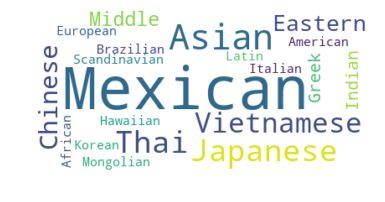

,City,1st Most Common Cuisine,2nd Most Common Cuisine,3rd Most Common Cuisine,4th Most Common Cuisine,5th Most Common Cuisine,6th Most Common Cuisine,7th Most Common Cuisine,8th Most Common Cuisine,9th Most Common Cuisine,10th Most Common Cuisine
5,Phoenix,Mexican,Italian,Chinese,Mediterranean,Middle Eastern,Peruvian,Asian,Indian,Vietnamese,Thai
7,San Antonio,Mexican,Italian,Japanese,Modern European,Asian,Brazilian,Chinese,German,Greek,Latin American
20,Indianapolis,Mexican,Italian,Japanese,Modern European,Greek,German,Middle Eastern,Indian,Thai,Caribbean
27,El Paso,Mexican,Italian,Japanese,Thai,Chinese,Israeli,Spanish,Asian,Mediterranean,Eastern European
39,Albuquerque,Mexican,Italian,Japanese,Middle Eastern,Asian,Caribbean,Modern European,Indian,French,Latin American
40,Tucson,Mexican,Italian,Chinese,French,Indian,Vietnamese,African,Asian,Middle Eastern,South American
43,Fresno,Mexican,Italian,Asian,Chinese,Vietnamese,Japanese,Mediterranean,Greek,South East Asian,Cuban
66,Aurora,Mexican,Italian,Chinese,Asian,Vietnamese,Thai,Indian,African,German,Korean
72,Corpus Christi,Mexican,Italian,Chinese,Vietnamese,Asian,Japanese,Thai,Mediterranean,Spanish,East European
75,Stockton,Mexican,Italian,Chinese,Japanese,Thai,Middle Eastern,Asian,Filipino,Greek,Indian


In [223]:
cluster=1
restaurants_cluster=restaurants_merged.loc[restaurants_merged['Cluster Labels'] == cluster-1, restaurants_merged.columns[[0] + list(range(5, restaurants_merged.shape[1]))]]
print(restaurants_cluster.shape[0])
cluster_cloud = WordCloud(background_color='white',max_words=20000,stopwords=STOPWORDS)

# generate string of all cuisines from dataframe
cluster_str=return_str(restaurants_cluster.iloc[:,:7],cluster-1)
# generate the word cloud
cluster_cloud.generate(cluster_str)

# display the word cloud
plt.imshow(cluster_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

restaurants_cluster.drop('Cluster Labels',axis=1)

#### Cluster 2 - Mexican and Asian (USA, western skewed)

99


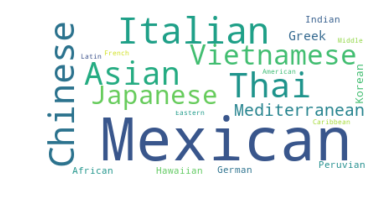

,City,1st Most Common Cuisine,2nd Most Common Cuisine,3rd Most Common Cuisine,4th Most Common Cuisine,5th Most Common Cuisine,6th Most Common Cuisine,7th Most Common Cuisine,8th Most Common Cuisine,9th Most Common Cuisine,10th Most Common Cuisine
9,Dallas,Mexican,Japanese,Italian,Thai,African,Asian,Latin American,Vietnamese,Portuguese,Peruvian
11,San Jose,Mexican,Japanese,Italian,Vietnamese,Greek,African,Korean,Asian,Chinese,German
12,Austin,Mexican,Italian,Japanese,Indian,Chinese,Korean,Latin American,Mediterranean,Vietnamese,Thai
13,Ottawa,Italian,Mexican,Spanish,Greek,Japanese,Middle Eastern,Asian,Chinese,Vietnamese,German
15,Jacksonville,Mexican,Italian,Japanese,Thai,Asian,Caribbean,Mediterranean,Spanish,French,Cuban
16,Fort Worth,Mexican,Italian,Japanese,Mediterranean,Thai,Chinese,Middle Eastern,Brazilian,French,German
17,Columbus,Italian,Mexican,German,Japanese,Asian,Greek,Latin American,Mongolian,Brazilian,Indian
32,Las Vegas,Mexican,Italian,Thai,Japanese,Hawaiian,Latin American,Modern European,Argentinian,Asian,Cuban
38,Milwaukee,Mexican,Italian,Chinese,Greek,Japanese,African,Asian,Vietnamese,Thai,Spanish
44,Mesa,Mexican,Italian,Asian,Chinese,Korean,Thai,South American,Greek,Indian,Japanese


In [209]:
cluster=2
restaurants_cluster=restaurants_merged.loc[restaurants_merged['Cluster Labels'] == cluster-1, restaurants_merged.columns[[0] + list(range(5, restaurants_merged.shape[1]))]]
print(restaurants_cluster.shape[0])
cluster_cloud = WordCloud(background_color='white',max_words=20000,stopwords=STOPWORDS)

# generate string of all cuisines from dataframe
cluster_str=return_str(restaurants_cluster.iloc[:,:7],cluster-1)
# generate the word cloud
cluster_cloud.generate(cluster_str)

# display the word cloud
plt.imshow(cluster_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

restaurants_cluster.drop('Cluster Labels',axis=1)

#### Cluster 3 - Mediterranean and Asian (USA, eastern skewed)

93


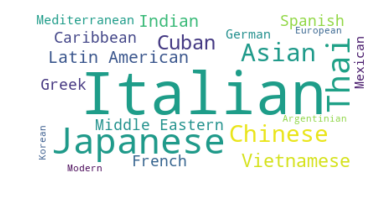

,City,1st Most Common Cuisine,2nd Most Common Cuisine,3rd Most Common Cuisine,4th Most Common Cuisine,5th Most Common Cuisine,6th Most Common Cuisine,7th Most Common Cuisine,8th Most Common Cuisine,9th Most Common Cuisine,10th Most Common Cuisine
8,San Diego,Italian,Mexican,Japanese,Middle Eastern,Thai,Brazilian,Israeli,Spanish,Argentinian,Turkish
22,Denver,Italian,Mexican,Asian,Japanese,Mediterranean,Middle Eastern,French,Latin American,Indian,Thai
28,Nashville,Italian,Mexican,Greek,Indian,Modern European,Asian,Caribbean,Chinese,Vietnamese,Thai
29,Detroit,Italian,Mexican,Thai,Greek,Japanese,Mediterranean,Middle Eastern,Chinese,Cuban,East European
50,Omaha,Italian,Mexican,Japanese,Chinese,French,African,Asian,Greek,Israeli,Vietnamese
52,Miami,Italian,Mexican,Japanese,Peruvian,Spanish,Argentinian,Cuban,Latin American,Asian,Chinese
53,Virginia Beach,Italian,Mexican,Mediterranean,Thai,Japanese,Modern European,Latin American,Indian,Caribbean,Chinese
59,Tampa,Italian,Mexican,Japanese,Spanish,Cuban,Mediterranean,Asian,Greek,Latin American,Argentinian
70,Riverside,Italian,Mexican,Thai,Japanese,Chinese,Indian,Vietnamese,Asian,Latin American,Scandinavian
74,Henderson,Italian,Mexican,Chinese,Thai,Japanese,Greek,Hawaiian,Brazilian,Caribbean,Australian


In [210]:
cluster=3
restaurants_cluster=restaurants_merged.loc[restaurants_merged['Cluster Labels'] == cluster-1, restaurants_merged.columns[[0] + list(range(5, restaurants_merged.shape[1]))]]
print(restaurants_cluster.shape[0])
cluster_cloud = WordCloud(background_color='white',max_words=20000,stopwords=STOPWORDS)

# generate string of all cuisines from dataframe
cluster_str=return_str(restaurants_cluster.iloc[:,:7],cluster-1)
# generate the word cloud
cluster_cloud.generate(cluster_str)

# display the word cloud
plt.imshow(cluster_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

restaurants_cluster.drop('Cluster Labels',axis=1)

#### Cluster 4 - predominantly Asian (Canada and Eastern USA + Alaska + Hawaii)

60


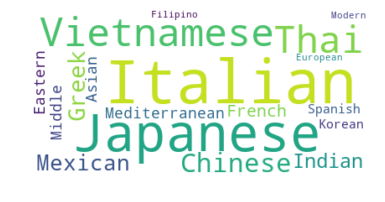

,City,1st Most Common Cuisine,2nd Most Common Cuisine,3rd Most Common Cuisine,4th Most Common Cuisine,5th Most Common Cuisine,6th Most Common Cuisine,7th Most Common Cuisine,8th Most Common Cuisine,9th Most Common Cuisine,10th Most Common Cuisine
1,Los Angeles,Japanese,Mexican,Italian,Chinese,French,Asian,Mediterranean,Brazilian,Filipino,German
2,Toronto,Italian,Japanese,Mexican,French,Thai,Hawaiian,Middle Eastern,Chinese,Indian,Turkish
4,Montreal,Italian,Portuguese,French,Japanese,Mexican,Middle Eastern,Vietnamese,Thai,Asian,Greek
6,Philadelphia,Japanese,Italian,Mexican,Chinese,Modern European,Asian,French,Israeli,German,Mediterranean
14,Edmonton,Italian,Japanese,Mexican,Thai,Chinese,Indian,Vietnamese,South East Asian,Scandinavian,Mediterranean
19,San Francisco,Vietnamese,Japanese,Italian,Mexican,Mediterranean,Thai,French,Latin American,South East Asian,African
21,Seattle,Vietnamese,Italian,Japanese,Mexican,French,Chinese,Hawaiian,Middle Eastern,Thai,Turkish
23,Mississauga,Indian,Italian,Japanese,Asian,Vietnamese,Mexican,Chinese,Caribbean,Portuguese,Korean
24,Washington,Italian,Mexican,Mediterranean,Japanese,Indian,Spanish,Portuguese,Israeli,French,Peruvian
25,Winnipeg,Italian,Japanese,Asian,French,Vietnamese,Indian,Chinese,Greek,Thai,Korean


In [215]:
cluster=4
restaurants_cluster=restaurants_merged.loc[restaurants_merged['Cluster Labels'] == cluster-1, restaurants_merged.columns[[0] + list(range(5, restaurants_merged.shape[1]))]]
print(restaurants_cluster.shape[0])
cluster_cloud = WordCloud(background_color='white',max_words=20000,stopwords=STOPWORDS)

# generate string of all cuisines from dataframe
cluster_str=return_str(restaurants_cluster.iloc[:,:7],cluster-1)
# generate the word cloud
cluster_cloud.generate(cluster_str)

# display the word cloud
plt.imshow(cluster_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

restaurants_cluster.drop('Cluster Labels',axis=1)

#### Cluster 5 - predominantly Mediterranean/European (Eastern USA and Canada)

46


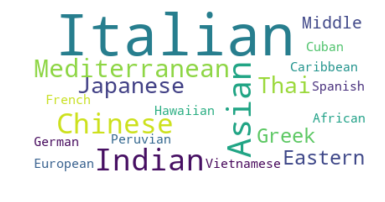

,City,1st Most Common Cuisine,2nd Most Common Cuisine,3rd Most Common Cuisine,4th Most Common Cuisine,5th Most Common Cuisine,6th Most Common Cuisine,7th Most Common Cuisine,8th Most Common Cuisine,9th Most Common Cuisine,10th Most Common Cuisine
0,New York,Italian,Israeli,French,Mexican,African,Caribbean,Chinese,Indian,Japanese,Mediterranean
3,Chicago,Italian,Japanese,Mexican,Middle Eastern,Cuban,French,Latin American,Mediterranean,Greek,Portuguese
10,Calgary,Italian,Japanese,Mediterranean,Asian,Chinese,French,Korean,Vietnamese,Argentinian,Middle Eastern
18,Charlotte,Italian,Mexican,Japanese,Thai,Mediterranean,Peruvian,French,Indian,Korean,Latin American
26,Boston,Italian,Mexican,French,Greek,Japanese,Asian,Chinese,Latin American,Australian,Thai
35,Louisville,Italian,Mexican,Japanese,Mediterranean,Asian,Chinese,African,Israeli,Brazilian,Latin American
56,Laval,Italian,Japanese,French,Mexican,Asian,Chinese,Brazilian,Greek,Israeli,Vietnamese
77,Vaughan,Italian,Japanese,Vietnamese,Chinese,Caribbean,Thai,Asian,Eastern European,East European,Middle Eastern
88,Toledo,Italian,Chinese,Mexican,Asian,Greek,Japanese,Mediterranean,Middle Eastern,Filipino,German
102,Norfolk,Italian,Mexican,Chinese,Japanese,Mediterranean,Asian,French,German,Greek,Vietnamese


In [213]:
cluster=5
restaurants_cluster=restaurants_merged.loc[restaurants_merged['Cluster Labels'] == cluster-1, restaurants_merged.columns[[0] + list(range(5, restaurants_merged.shape[1]))]]
print(restaurants_cluster.shape[0])
cluster_cloud = WordCloud(background_color='white',max_words=20000,stopwords=STOPWORDS)

# generate string of all cuisines from dataframe
cluster_str=return_str(restaurants_cluster.iloc[:,:7],cluster-1)
# generate the word cloud
cluster_cloud.generate(cluster_str)

# display the word cloud
plt.imshow(cluster_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

restaurants_cluster.drop('Cluster Labels',axis=1)

## Conclusion

Having analysed 5 clusters, we would classify foreign cuisine in USA/Canada into the following groups. 
1. cluster dominates the Southern USA with a Mexican centered Cuisine
1. cluster present in whole USA but more concentrated in the western part, features Mexican and Asian food
1. cluster distributed in whole USA, slighlty favouring the eastern part, represents Mediterranean and Asian cuisine
1. cluster spread throughout Canada and Eastern USA, mostly Asian cuisines
1. cluster placed in Canada and Eastern USA, features Mediterranean/European cuisine

In [246]:
display(map_clusters)